In [ ]:
######################
# So you want to train a Neural CDE model?
# Let's get started!
######################
import math
import torch
import torchcde
import math
import torch
import torchcde
from get_data import *
from dataloader import *
from test_function import *
from tqdm import tqdm
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(device)

In [ ]:

######################
# A CDE model looks like
#
# z_t = z_0 + \int_0^t f_\theta(z_s) dX_s
#
#    Where X is your data and f_\theta is a neural network. So the first thing we need to do is define such an f_\theta.
# That's what this CDEFunc class does.
# Here we've built a small single-hidden-layer neural network, whose hidden layer is of width 128.
######################
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, hidden_width=128):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.hidden_width  = hidden_width

        self.linear1 = torch.nn.Linear(hidden_channels, self.hidden_width)
        self.linear2 = torch.nn.Linear(self.hidden_width, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z


# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, hidden_width, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels, hidden_width)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval, atol = 1e-4)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y
######################



torch.Size([2, 550, 4])
torch.Size([1, 550, 4])


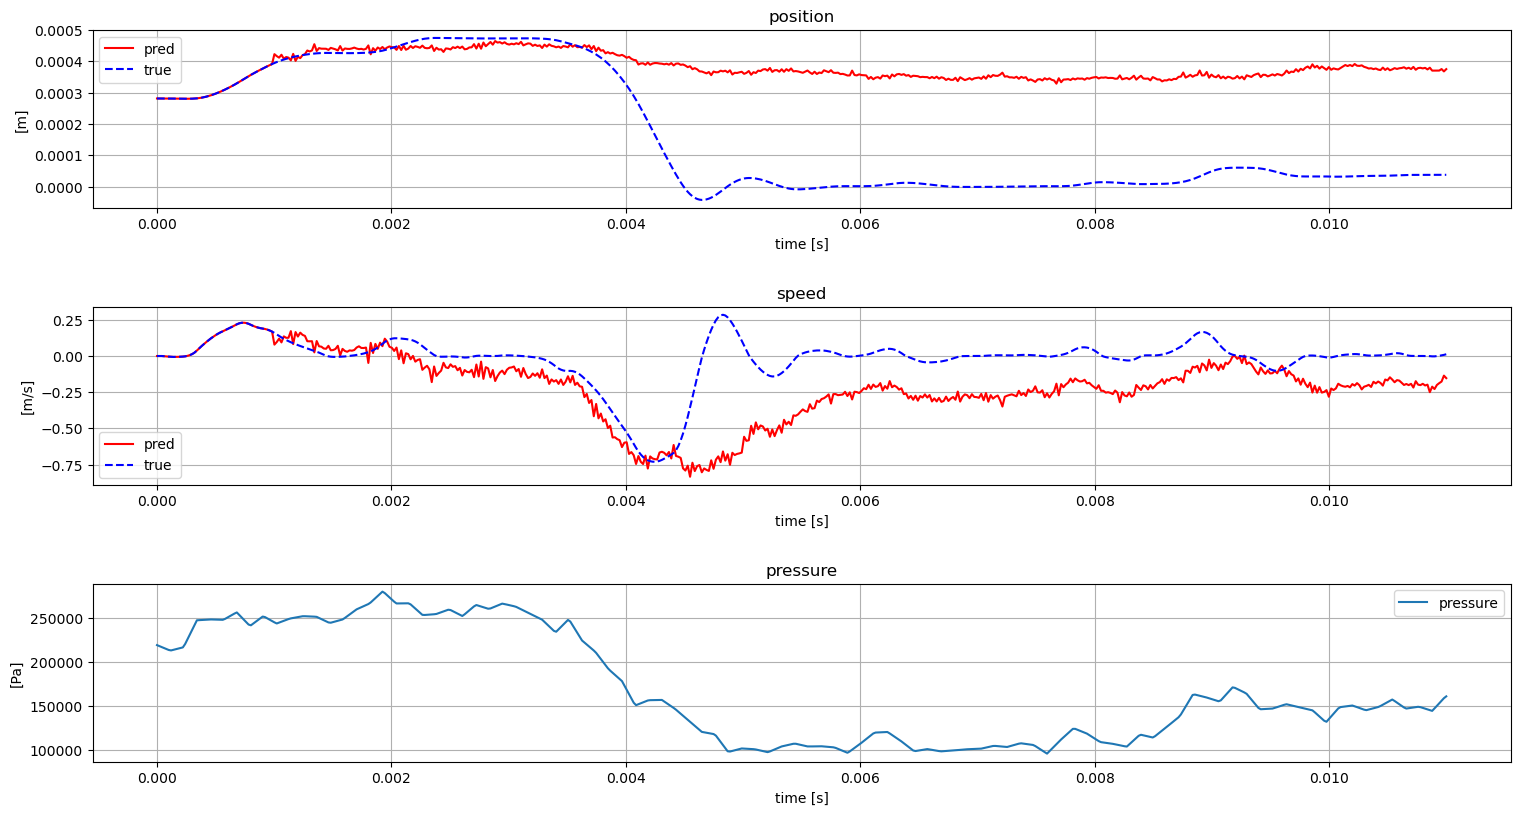

Test loss (MSE over whole Traj.): 0.10422061982970261


In [7]:
#Testing

path = "Ventil_trained_NNs\cde0.pth"

paramsliste =        [            {
                        "experiment_number" : 0,
                        "window_size" : 50,
                        "h_size" : 8,
                        "h_width" : 128,
                        "l_num" : 3,
                        "epochs" : 80,
                        "learning_rate" : 0.001,
                        "part_of_data" : 2, 
                        "percentage_of_data" : 0.8,
                        "batch_size" : 2,
                        "cut_off_timesteps" : 0,
                        "drop_half_timesteps": True
                        }
            ]

for params in paramsliste:

    input_data1, PSW_max = get_data_cde(path = "data\save_data_test_revised.csv", 
                                timesteps_from_data=0, 
                                skip_steps_start = 0,
                                skip_steps_end = 0, 
                                drop_half_timesteps = params["drop_half_timesteps"],
                                normalise_s_w="minmax",
                                rescale_p=False,
                                num_inits=params["part_of_data"])
    input_data = input_data1
    #cols = time_cols, pb_cols, sb_cols, wb_cols
    print(input_data.size())
        #Split data into train and test sets
    np.random.seed(1234)
    num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
    train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
    test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
    np.random.shuffle(train_inits)
    np.random.shuffle(test_inits)
    train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
    test_data = input_data[test_inits,:,:]
    print(train_data.size())

    train_set = CustomDataset_cde(train_data, window_size=params["window_size"])
    train_loader = DataLoader(train_set, batch_size=params["batch_size"])  
    if device == "cuda:0":
        train_loader = DataLoader(train_set, batch_size=params["batch_size"], pin_memory=True)  

    model = NeuralCDE(input_channels=4, hidden_channels=params["h_size"], hidden_width = params["h_width"], output_channels=2).to(device)
    model.load_state_dict(torch.load(path, map_location=torch.device(device)))

           
    test_loss, test_loss_deriv, err_test = test(train_data.to(device), model, model_type = "neural_cde", window_size=params["window_size"], 
                                                display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max)
    print('Test loss (MSE over whole Traj.): {}'.format(err_test.item()))



